In [2]:
import os
import numpy as np
import glob

dataset_path = "/kaggle/input/opbtd-all"
image_files = sorted(glob.glob(os.path.join(dataset_path, "**", "images.npy"), recursive=True))
mask_files = sorted(glob.glob(os.path.join(dataset_path, "**", "masks.npy"), recursive=True))

print(image_files)
print(mask_files)


['/kaggle/input/opbtd-all/OPBTD1/OPBTD1/images.npy', '/kaggle/input/opbtd-all/OPBTD2/OPBTD2/images.npy', '/kaggle/input/opbtd-all/OPBTD3/OPBTD3/images.npy', '/kaggle/input/opbtd-all/OPBTDAG/OPBTDAG/images.npy']
['/kaggle/input/opbtd-all/OPBTD1/OPBTD1/masks.npy', '/kaggle/input/opbtd-all/OPBTD2/OPBTD2/masks.npy', '/kaggle/input/opbtd-all/OPBTD3/OPBTD3/masks.npy', '/kaggle/input/opbtd-all/OPBTDAG/OPBTDAG/masks.npy']


In [15]:
import numpy as np

if len(image_files) > 0 and len(mask_files) > 0:
    images = np.concatenate([np.load(f) for f in image_files], axis=0)
    masks = np.concatenate([np.load(f) for f in mask_files], axis=0)

    print(f"Combined Data: Images Shape: {images.shape}, Masks Shape: {masks.shape}")
    print("Saved")
else:
    print("ERROR")


Combined Data: Images Shape: (3064, 256, 256), Masks Shape: (3064, 256, 256)
Saved


In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
images = images.astype(np.float32) / 255.0
masks = masks.astype(np.float32) 
images = np.expand_dims(images, axis=-1)  
masks = np.expand_dims(masks, axis=-1)    
X_train, X_val, Y_train, Y_val = train_test_split(images, masks, test_size=0.2, random_state=42)

print(f"Data Prepared: Train: {X_train.shape}, Val: {X_val.shape}")


Data Prepared: Train: (2451, 256, 256, 1), Val: (613, 256, 256, 1)


In [5]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate

def unet_model(input_shape=(256, 256, 1)):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    p3 = MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = Conv2D(512, (3, 3), activation="relu", padding="same")(c4)

    # Decoder
    u1 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c4)
    u1 = concatenate([u1, c3])
    c5 = Conv2D(256, (3, 3), activation="relu", padding="same")(u1)
    c5 = Conv2D(256, (3, 3), activation="relu", padding="same")(c5)

    u2 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
    u2 = concatenate([u2, c2])
    c6 = Conv2D(128, (3, 3), activation="relu", padding="same")(u2)
    c6 = Conv2D(128, (3, 3), activation="relu", padding="same")(c6)

    u3 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
    u3 = concatenate([u3, c1])
    c7 = Conv2D(64, (3, 3), activation="relu", padding="same")(u3)
    c7 = Conv2D(64, (3, 3), activation="relu", padding="same")(c7)

    outputs = Conv2D(1, (1, 1), activation="sigmoid")(c7) 

    return Model(inputs, outputs)
model = unet_model()
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 256, 256, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 256, 256, 64)   │            640 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 256, 256, 64)   │         36,928 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 128, 128, 64)   │              0 │ conv2d_1[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 128, 128, 128)  │         73,856 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 128, 128, 128)  │        147,584 │ conv2d_2[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 64, 64, 128)    │              0 │ conv2d_3[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 64, 64, 256)    │        295,168 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_2           │ (None, 32, 32, 256)    │              0 │ conv2d_5[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 512)    │      1,180,160 │ max_pooling2d_2[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 32, 32, 512)    │      2,359,808 │ conv2d_6[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 64, 64, 256)    │        524,544 │ conv2d_7[0][0]         │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 64, 64, 512)    │              0 │ conv2d_transpose[0][0… │
│                           │                        │                │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_8 (Conv2D)         │ (None, 64, 64, 256)    │      1,179,904 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_9 (Conv2D)         │ (None, 64, 64, 256)    │        590,080 │ conv2d_8[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 128, 128, 128)  │        131,200 │ conv2d_9[0][0]         │
│ (Conv2DTranspose)    

 Total params: 7,696,193 (29.36 MB)

 Trainable params: 7,696,193 (29.36 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
batch_size = 10
epochs = 15
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    batch_size=batch_size,
    epochs=epochs
)


Epoch 1/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 212s 676ms/step - accuracy: 0.9689 - loss: 0.1482 - val_accuracy: 0.9837 - val_loss: 0.0777
Epoch 2/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 120s 489ms/step - accuracy: 0.9831 - loss: 0.0798 - val_accuracy: 0.9837 - val_loss: 0.0735
Epoch 3/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 119s 483ms/step - accuracy: 0.9827 - loss: 0.0780 - val_accuracy: 0.9837 - val_loss: 0.0738
Epoch 4/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 118s 481ms/step - accuracy: 0.9830 - loss: 0.0799 - val_accuracy: 0.9837 - val_loss: 0.0763
Epoch 5/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 119s 483ms/step - accuracy: 0.9827 - loss: 0.0817 - val_accuracy: 0.9837 - val_loss: 0.0744
Epoch 6/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 119s 482ms/step - accuracy: 0.9828 - loss: 0.0779 - val_accuracy: 0.9837 - val_loss: 0.0735
Epoch 7/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 119s 483ms/step - accuracy: 0.9831 - loss: 0.0732 - val_accuracy: 0.9837 - val_loss: 0.0754
Epoch 8/15
246/246 ━━━━━━━━━━━━━━━━━━━━ 119s 484ms/step - accuracy: 0.9829 -

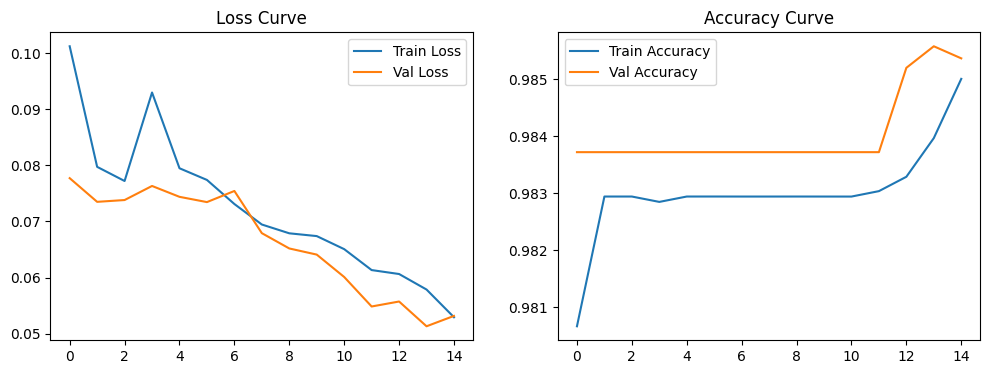

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


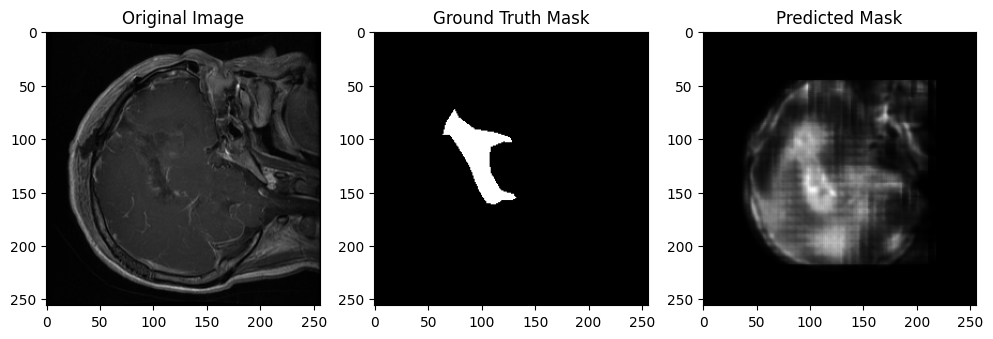

In [8]:
import random
idx = random.randint(0, len(X_val) - 1)
image_sample = X_val[idx:idx+1]
pred_mask = model.predict(image_sample)[0]
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(X_val[idx, :, :, 0], cmap="gray")
axes[0].set_title("Original Image")

axes[1].imshow(Y_val[idx, :, :, 0], cmap="gray")
axes[1].set_title("Ground Truth Mask")

axes[2].imshow(pred_mask[:, :, 0], cmap="gray")
axes[2].set_title("Predicted Mask")

plt.show()


In [10]:
import numpy as np
import scipy.stats as stats

tumor_volumes = np.sum(Y_val, axis=(1, 2, 3)) 
group_1 = tumor_volumes[:len(tumor_volumes)//2]  # First half
group_2 = tumor_volumes[len(tumor_volumes)//2:]  # Second half
t_stat, p_value = stats.ttest_ind(group_1, group_2)

print(f"T-Test Results: t-statistic = {t_stat:.3f}, p-value = {p_value:.5f}")
if p_value < 0.05:
    print("Great difference in tumor sizes between cohorts.")
else:
    print("No good difference between the two groups.")


T-Test Results: t-statistic = -1.488, p-value = 0.13732
No good difference between the two groups.


In [11]:

group_1 = tumor_volumes[:len(tumor_volumes)//3]
group_2 = tumor_volumes[len(tumor_volumes)//3 : 2*len(tumor_volumes)//3]
group_3 = tumor_volumes[2*len(tumor_volumes)//3:]

f_stat, p_value_anova = stats.f_oneway(group_1, group_2, group_3)

print(f"ANOVA Results: F-statistic = {f_stat:.3f}, p-value = {p_value_anova:.5f}")

if p_value_anova < 0.05:
    print("Great difference in tumor volumes across patient groups.")
else:
    print("No significant difference between groups.")


ANOVA Results: F-statistic = 0.862, p-value = 0.42272
No significant difference between groups.


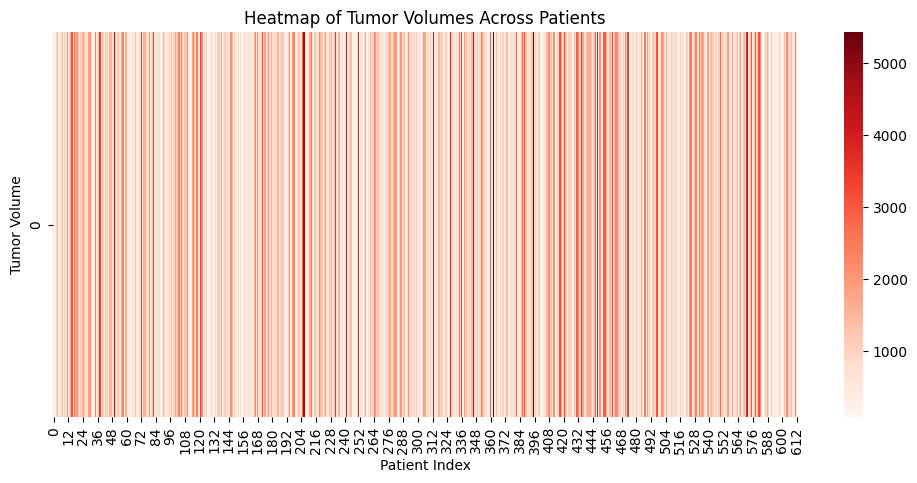

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.heatmap(tumor_volumes.reshape(1, -1), cmap="Reds", annot=False, cbar=True)
plt.title("Heatmap of Tumor Volumes Across Patients")
plt.xlabel("Patient Index")
plt.ylabel("Tumor Volume")
plt.show()


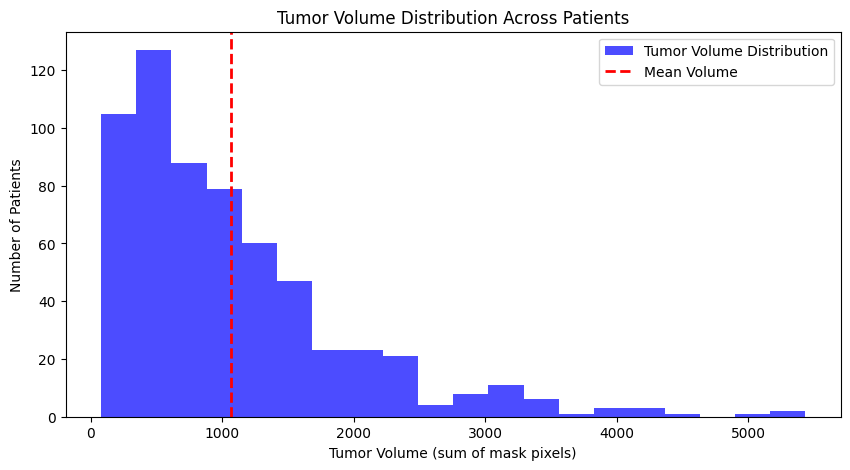

In [13]:
plt.figure(figsize=(10, 5))
plt.hist(tumor_volumes, bins=20, color="blue", alpha=0.7, label="Tumor Volume Distribution")
plt.axvline(np.mean(tumor_volumes), color="red", linestyle="dashed", linewidth=2, label="Mean Volume")
plt.xlabel("Tumor Volume (sum of mask pixels)")
plt.ylabel("Number of Patients")
plt.title("Tumor Volume Distribution Across Patients")
plt.legend()
plt.show()


In [9]:
model.save("brain_tumor_segmentation.h5")
print("Model saved")


Model saved
